# Titatanic survivors data analysis

## Initialisation

In [1]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline

/Users/Baker/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Baker/anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Data preparation

### Load data

In [2]:
train = pd.read_pickle('../data/train_prep.pkl')
test = pd.read_pickle('../data/test_prep.pkl')

In [3]:
outcome = pd.read_csv('../data/train.csv', usecols=['Survived'], squeeze=True)
testId = pd.read_csv('../data/test.csv', usecols=['PassengerId'], squeeze=True)

### Prepare X and y matrices

In [4]:
X = train
y = outcome
Xtr, Xval, ytr, yval = train_test_split(X, y, test_size=0.15, random_state=777)

In [5]:
Xtr.shape, Xval.shape

((757, 17), (134, 17))

## Naive prediction

In [6]:
womenSurvidedProportion = y[X.IsMale == False].mean()
menSurvidedProportion = y[X.IsMale == True].mean()
print('Proportion of women who survived is %s' % womenSurvidedProportion)
print('Proportion of men who survived is %s' % menSurvidedProportion)

Proportion of women who survived is 0.7420382165605095
Proportion of men who survived is 0.18890814558058924


In [7]:
womenProportion = (X.IsMale == False).mean()
menProportion = (X.IsMale == True).mean()

naivePrediction = womenProportion * womenSurvidedProportion + menProportion * (1 - menSurvidedProportion)
print('Naive correct prediction: %s' % naivePrediction)

Naive correct prediction: 0.786756453423


## Logistic regression

### First run

In [8]:
lr = LogisticRegression()
lr.fit(Xtr, ytr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [9]:
(lr.predict(Xtr) == ytr).mean()

0.84147952443857332

In [10]:
lr.score(Xtr, ytr)

0.84147952443857332

In [11]:
print('Train correct prediction: ', lr.score(Xtr, ytr))
print('Validation correct prediction: ', lr.score(Xval, yval))

Train correct prediction:  0.841479524439
Validation correct prediction:  0.820895522388


### Parameters optimisation

In [12]:
Cs = 10**np.linspace(-4, 4, num=15)
Cs

array([  1.00000000e-04,   3.72759372e-04,   1.38949549e-03,
         5.17947468e-03,   1.93069773e-02,   7.19685673e-02,
         2.68269580e-01,   1.00000000e+00,   3.72759372e+00,
         1.38949549e+01,   5.17947468e+01,   1.93069773e+02,
         7.19685673e+02,   2.68269580e+03,   1.00000000e+04])

In [13]:
grid = {'C': Cs}
gridsearch = GridSearchCV(LogisticRegression(), grid, cv=10)

In [14]:
%time gridsearch.fit(Xtr, ytr)

CPU times: user 832 ms, sys: 2.6 ms, total: 834 ms
Wall time: 834 ms


GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-04,   3.72759e-04,   1.38950e-03,   5.17947e-03,
         1.93070e-02,   7.19686e-02,   2.68270e-01,   1.00000e+00,
         3.72759e+00,   1.38950e+01,   5.17947e+01,   1.93070e+02,
         7.19686e+02,   2.68270e+03,   1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [15]:
gridsearch.best_estimator_

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [16]:
scores = [x.mean_validation_score for x in  gridsearch.grid_scores_]

Best lambda:  1.0
Maximum validation score:  0.8309114927344782


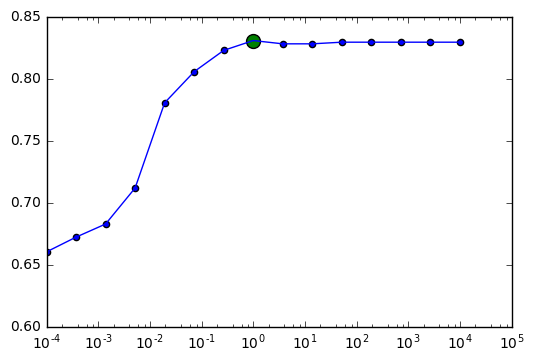

In [17]:
plt.plot(Cs, scores)
plt.scatter(Cs, scores)
plt.scatter(Cs[np.argmax(scores)], scores[np.argmax(scores)], c='g', s=100)
plt.xscale('log')
print('Best lambda: ', Cs[np.argmax(scores)])
print('Maximum validation score: ', scores[np.argmax(scores)])

In [18]:
C = Cs[np.argmax(scores)]
lr = LogisticRegression(C=C)
lr.fit(Xtr, ytr)
print('Train correct prediction: ', lr.score(Xtr, ytr))
print('Validation correct prediction: ', lr.score(Xval, yval))

Train correct prediction:  0.841479524439
Validation correct prediction:  0.820895522388


In [19]:
lr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [20]:
lr_pred = lr.predict(test)

In [21]:
lr_pred

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0,

In [22]:
lr_submit = pd.DataFrame({'PassengerId': testId, 'Survived': lr_pred})

In [23]:
lr_submit.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [85]:
lr_submit.to_csv('../output/2016-04-27-bff-logistic-regression.csv', index=False)

## Random forest

In [69]:
rf = RandomForestClassifier(n_estimators = 100)

In [87]:
rf.fit(Xtr, ytr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [88]:
print('Train correct prediction: ', rf.score(Xtr, ytr))
print('Validation correct prediction: ', rf.score(Xval, yval))

Train correct prediction:  0.985468956407
Validation correct prediction:  0.798507462687


In [89]:
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [90]:
rf_pred = rf.predict(test)

In [76]:
rf_pred

array([0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0,

In [81]:
rf_submit = pd.DataFrame({'PassengerId': testId, 'Survived': rf_pred})

In [86]:
rf_submit.to_csv('../output/2016-04-28-bff-random-forest.csv', index=False)

In [21]:
submit = pd.DataFrame({'PassengerId': testId, 'Survived': prediction})

In [34]:
submit.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [37]:
submit.to_csv('../output/2016-04-27-bff-logistic-regression.csv', index=False)